In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm  # For progress tracking

# Ensure necessary NLTK resources are available
import nltk
nltk.data.path.append("/usr/local/share/nltk_data")  # Adjust this path if necessary
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Step 1: Load company dataset
company_df = pd.read_csv("ml_insurance_challenge.csv")


In [3]:
# Step 2: Load insurance taxonomy labels with corresponding insurance types
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()
print(insurance_labels)
#remove the first element
insurance_labels = insurance_labels[1:]
print(insurance_labels)


['label', 'Agricultural Equipment Services', 'Soil Nutrient Application Services', 'Pesticide Application Services', 'Ornamental Plant Nurseries', 'Landscaping Services', 'Gardening Services', 'Tree Services - Pruning / Removal', 'Veterinary Services', 'Veterinary Clinics', 'Pet Boarding Services', 'Animal Day Care Services', 'Pet Grooming Services', 'Animal Training Services', 'Veterinary Health Centers', 'Animal Trainers', 'Livestock Dealer Services', 'Timber Harvesting Operations', 'Fishing and Hunting Services', 'Well Maintenance Services', 'Field Welding Services', 'Sand and Gravel Mining', 'Residential Driveway Construction', 'Commercial Driveway Construction', 'Fencing Construction Services', 'Sidewalk Construction Services', 'Commercial Irrigation Systems', 'Residential Drainage Systems', 'Residential Snow Removal', 'Commercial Snow Removal', 'General Snow Removal Services', 'Land Leveling Services', 'Residential Drain Cleaning', 'Commercial Drain Cleaning', 'Street Cleaning Op

In [4]:
# Step 3: Assign numerical labels to insurance categories
label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}

#Print the label to id mapping
print(label_to_id)
print(id_to_label)

#show the label of id 5
print(id_to_label[5])

{'Agricultural Equipment Services': 1, 'Soil Nutrient Application Services': 2, 'Pesticide Application Services': 3, 'Ornamental Plant Nurseries': 4, 'Landscaping Services': 5, 'Gardening Services': 6, 'Tree Services - Pruning / Removal': 7, 'Veterinary Services': 8, 'Veterinary Clinics': 9, 'Pet Boarding Services': 10, 'Animal Day Care Services': 11, 'Pet Grooming Services': 12, 'Animal Training Services': 13, 'Veterinary Health Centers': 14, 'Animal Trainers': 15, 'Livestock Dealer Services': 16, 'Timber Harvesting Operations': 17, 'Fishing and Hunting Services': 18, 'Well Maintenance Services': 19, 'Field Welding Services': 20, 'Sand and Gravel Mining': 21, 'Residential Driveway Construction': 22, 'Commercial Driveway Construction': 23, 'Fencing Construction Services': 24, 'Sidewalk Construction Services': 25, 'Commercial Irrigation Systems': 26, 'Residential Drainage Systems': 27, 'Residential Snow Removal': 28, 'Commercial Snow Removal': 29, 'General Snow Removal Services': 30, 'L

In [5]:
# Step 4: Load GloVe word embeddings
def load_glove_embeddings(filepath, dim=300):
    embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings("glove.6B.300d.txt")

In [6]:
def text_to_glove_vector(text, glove_embeddings):
    words = text.split()  # Simple tokenization
    vectors = [glove_embeddings.get(word, np.zeros(300)) for word in words]  # Default to zero vector if word is unknown
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)


In [7]:
# Step 5: Preprocess text descriptions
def preprocess_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = re.findall(r'\b\w+\b', text)  # Alternative tokenization method
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [8]:
# 6 Preprocess all text columns
def preprocess_all_columns(row):
    # Combine text from all relevant columns into one string
    combined_text = " ".join([str(row[col]) for col in ['business_tags', "niche", "category", "description"]])
    
    # Preprocess the combined text
    return preprocess_text(combined_text)

In [9]:
# Apply the preprocessing function to all rows
company_df['processed_combined_text'] = company_df.apply(preprocess_all_columns, axis=1)

In [10]:
# 7 Convert preprocessed text to GloVe vectors
company_df['glove_vector'] = company_df['processed_combined_text'].apply(lambda x: text_to_glove_vector(x, glove_embeddings))

In [11]:
print(company_df[['description', 'business_tags', 'sector', 'category', 'niche', 'processed_combined_text', 'glove_vector']].head())

                                         description  \
0  Welchcivils is a civil engineering and constru...   
1  Kyoto Vegetable Specialists Uekamo, also known...   
2  Loidholdhof Integrative Hofgemeinschaft is a c...   
3  PATAGONIA Chapa Y Pintura is an auto body shop...   
4  Stanica WODNA PTTK Swornegacie is a cultural e...   

                                       business_tags         sector  \
0  ['Construction Services', 'Multi-utilities', '...       Services   
1  ['Wholesale', 'Dual-task Movement Products', '...  Manufacturing   
2  ['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...  Manufacturing   
3  ['Automotive Body Repair Services', 'Interior ...       Services   
4  ['Cultural Activities', 'Accommodation Service...       Services   

                               category  \
0            Civil Engineering Services   
1  Fruit & Vegetable - Markets & Stores   
2        Farms & Agriculture Production   
3                       Auto Body Shops   
4                  Bo

In [12]:
print(company_df['glove_vector'].head())

0    [-0.018807849222794173, 0.048310460411012175, ...
1    [-0.04697342262129653, 0.17967982795731774, 0....
2    [-0.1175709662872345, 0.22299840677053082, -0....
3    [0.20876358, 0.15946342, -0.2561853, -0.165433...
4    [0.03136063671924851, -0.11103307230355726, 0....
Name: glove_vector, dtype: object


In [13]:
# Step 8: Convert insurance labels to vectors
insurance_label_vectors = np.vstack([text_to_glove_vector(label, glove_embeddings) for label in insurance_labels])

In [14]:
# Step 9: Compute cosine similarity between company descriptions and insurance labels
company_vectors = np.vstack(company_df['glove_vector'].values)
similarity_matrix = cosine_similarity(company_vectors, insurance_label_vectors)

Oil and Fat Manufacturing
id: 131, label Counts: 9383
Roofing Services with Heat Application
id: 97, label Counts: 105
Tree Services - Pruning / Removal
id: 7, label Counts: 6


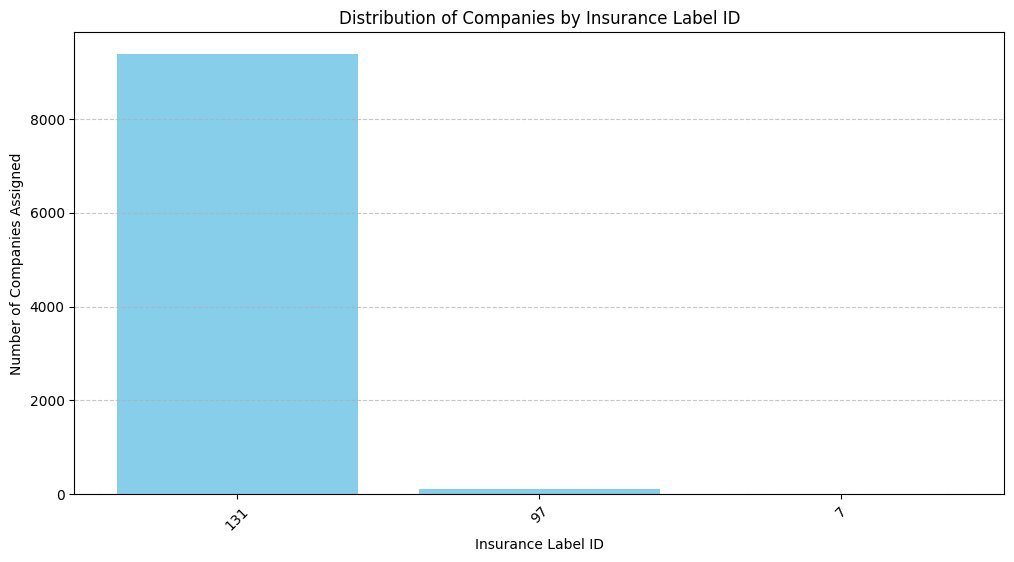

In [15]:
# Step 10: Assign labels to companies
def assign_labels(similarity_matrix, labels, label_to_id, top_n=1):
    top_indices = np.argsort(similarity_matrix, axis=1)[:, -top_n:][:, ::-1]
    
    assigned_labels = []
    
    for indices in top_indices:
        # Assign labels as numeric values
        numeric_labels = [label_to_id.get(labels[i], -1) for i in indices]
        assigned_labels.append(", ".join(map(str, numeric_labels)))
    
    return assigned_labels

# Re-run the assignment
company_df['insurance_label_id']= assign_labels(
    similarity_matrix, insurance_labels, label_to_id
)

# Step 3: Verify that the labels were added
#print(company_df['insurance_label_id'].head())

# Step 4: Now, you can generate the graph
# Exploding the 'insurance_label_id' column to handle multiple labels per company
exploded_labels = company_df['insurance_label_id'].str.split(', ', expand=True).stack()

# Count the occurrences of each label ID
label_counts = exploded_labels.value_counts()

#Print the label name with the label id and the number of companies assigned to that label
for label in label_counts.index:
    print(id_to_label[int(label)])
    print(f"id: {label}, label Counts: {label_counts[label]}")

# Step 5: Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Classification results saved to 'classified_companies.csv'


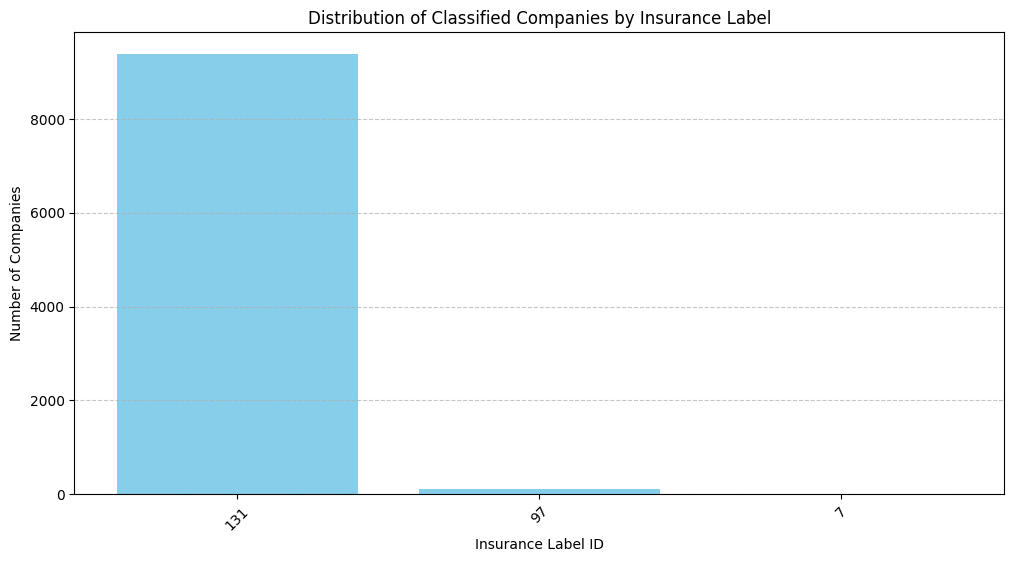

In [16]:
# Step 11: Save the classified companies to a CSV file
company_df.to_csv("classified_companies1.csv", index=False)
print("Classification results saved to 'classified_companies.csv'")

# Step 12: Generate bar chart of classified companies
label_counts = company_df['insurance_label_id'].explode().value_counts()
plt.figure(figsize=(12, 6))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies")
plt.title("Distribution of Classified Companies by Insurance Label")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Results saved to company_insurance_classification.csv
Agricultural Equipment Services (ID: 1) - 541 companies
Health and Safety Consulting (ID: 202) - 328 companies
Training Services (ID: 186) - 247 companies
Business Development Services (ID: 179) - 212 companies
Paper Production Services (ID: 149) - 180 companies
Food Safety Services (ID: 203) - 174 companies
Well Maintenance Services (ID: 19) - 166 companies
Furniture Manufacturing (ID: 147) - 157 companies
Children's Clothing Manufacturing (ID: 137) - 151 companies
Mobile Home Construction Services (ID: 108) - 150 companies
Market Research Services (ID: 184) - 137 companies
Water Treatment Services (ID: 64) - 134 companies
Wood Product Manufacturing (ID: 142) - 133 companies
Building Cleaning Services (ID: 100) - 132 companies
Animal Day Care Services (ID: 11) - 131 companies
Commercial Construction Services (ID: 109) - 126 companies
Online Marketing Services (ID: 193) - 116 companies
HVAC Installation and Service (ID: 61) - 111 co

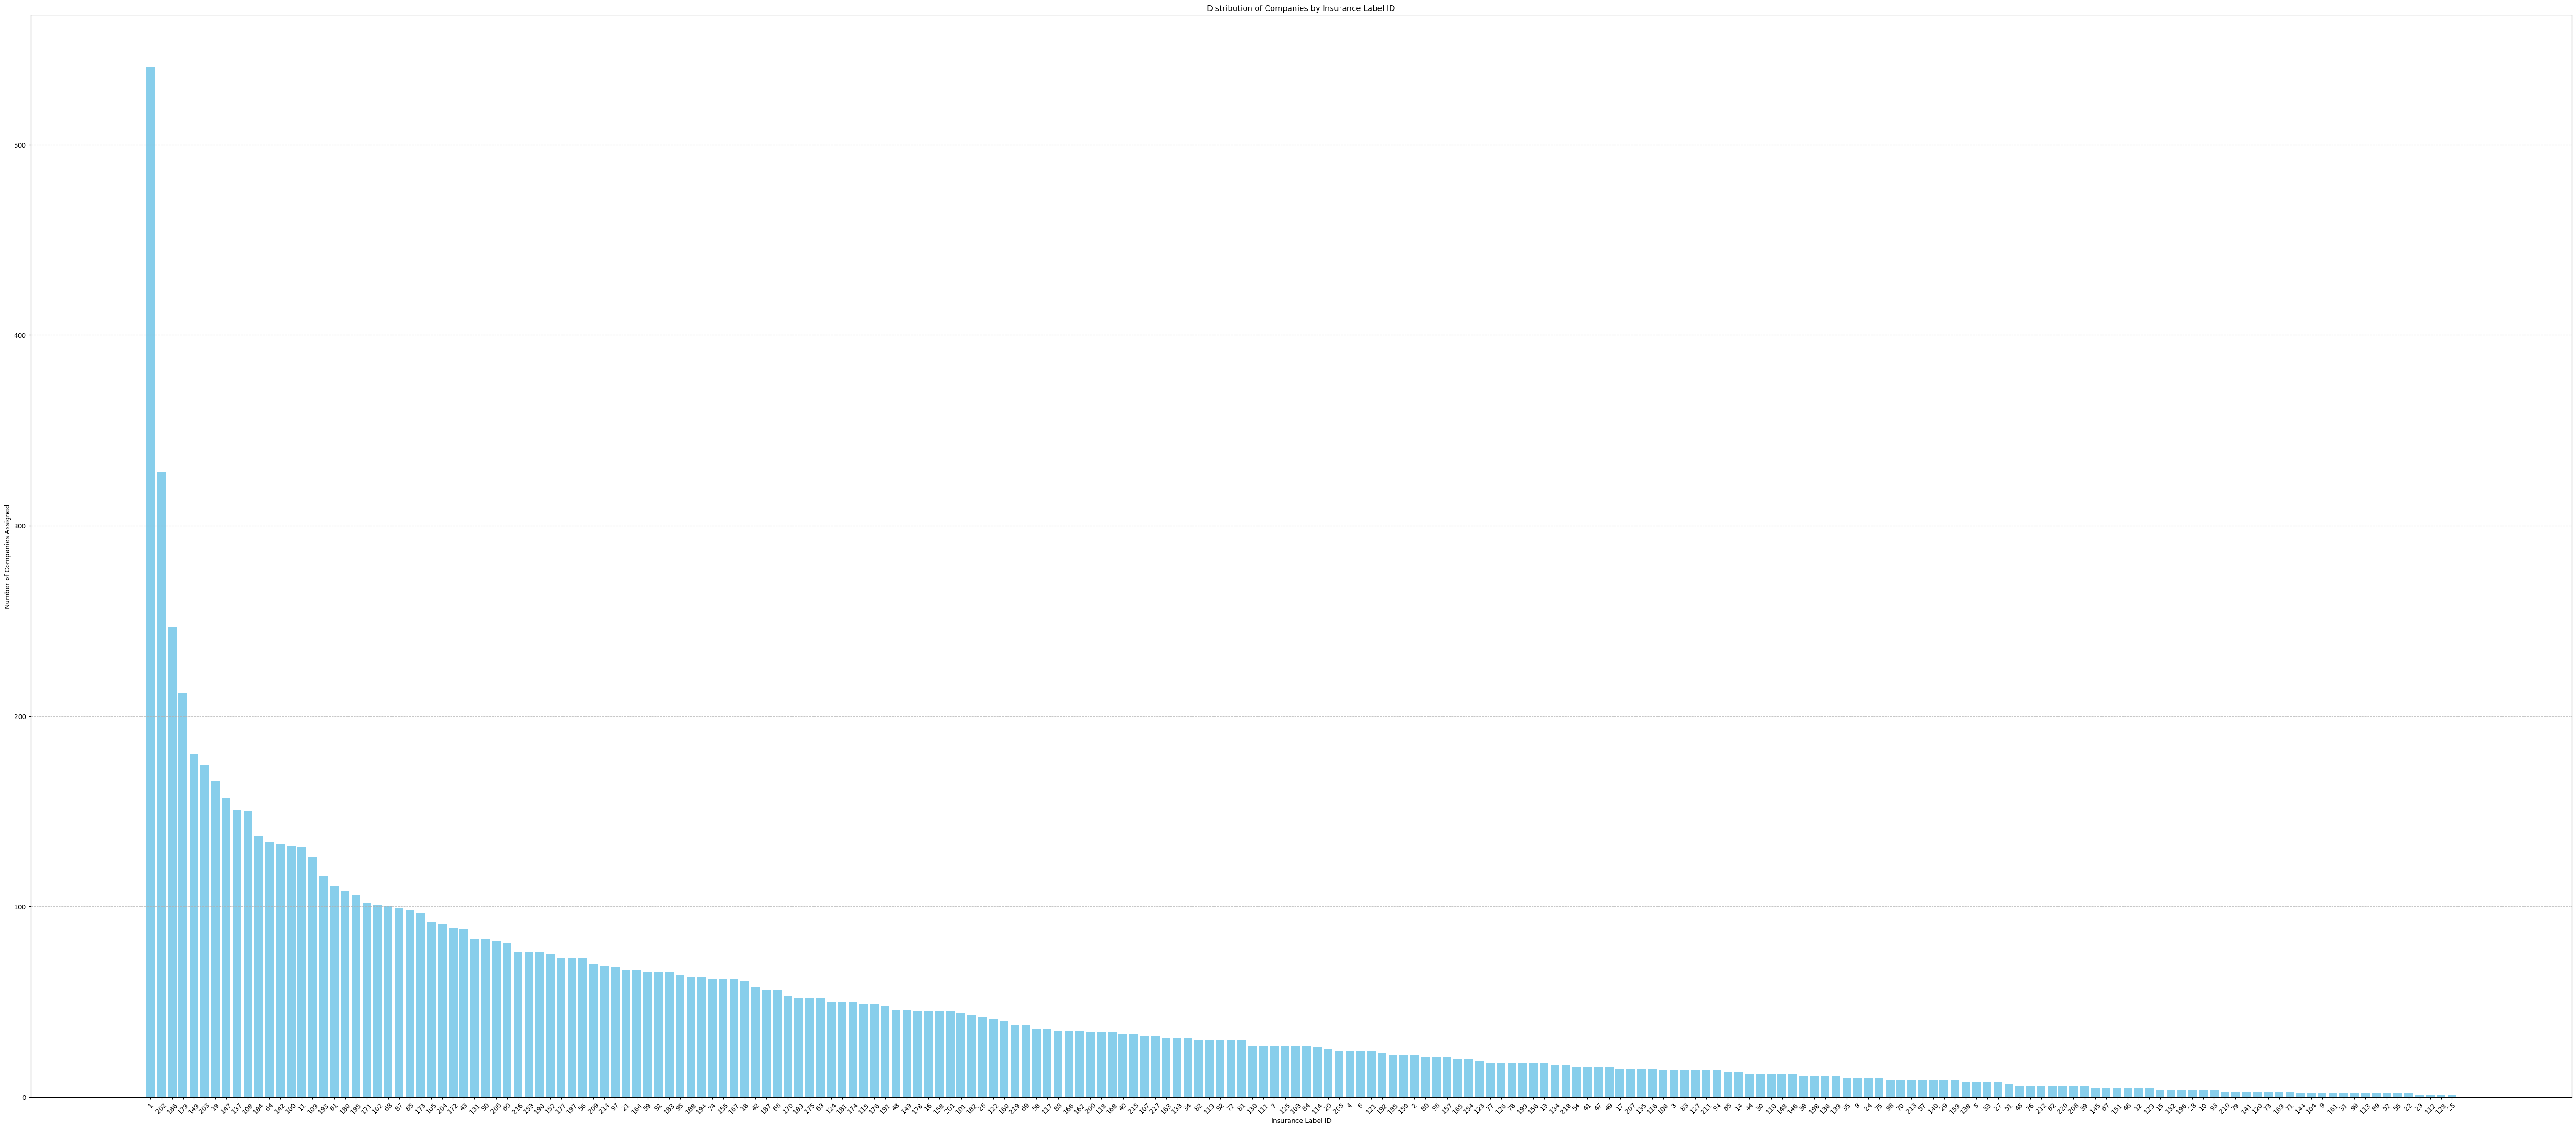

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def assign_labels(similarity_matrix, labels, label_to_id):
    top_indices = np.argmax(similarity_matrix, axis=1)
    
    assigned_labels = []
    
    for index in top_indices:
        # Assign labels as numeric values
        numeric_label = label_to_id.get(labels[index], -1)
        assigned_labels.append(numeric_label)
    
    return assigned_labels

# Load insurance taxonomy labels with corresponding insurance types
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()
insurance_labels = insurance_labels[1:]  # Remove the first element

# Assign numerical labels to insurance categories
label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}

# Load company data
company_df = pd.read_csv("ml_insurance_challenge.csv")  # Replace with actual data file

# Fill missing values in the 'description' column with an empty string
company_df['description'] = company_df['description'].fillna('')

# Combine company descriptions with insurance labels for TF-IDF vectorization
combined_texts = company_df['description'].tolist() + insurance_labels
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)
company_tfidf = tfidf_matrix[:len(company_df)]
label_tfidf = tfidf_matrix[len(company_df):]

# Compute similarity matrix
similarity_matrix = cosine_similarity(company_tfidf, label_tfidf)

# Assign labels
company_df['insurance_label_id'] = assign_labels(similarity_matrix, insurance_labels, label_to_id)

# Map label IDs back to label names
company_df['insurance_label_name'] = company_df['insurance_label_id'].map(id_to_label)

# Save results to a CSV file
output_file = "company_insurance_classification.csv"
company_df.to_csv(output_file, index=False)

print(f"Results saved to {output_file}")

# Count occurrences of each label ID
label_counts = company_df['insurance_label_id'].value_counts()

# Print label statistics
for label in label_counts.index:
    print(f"{id_to_label[int(label)]} (ID: {label}) - {label_counts[label]} companies")

# Create a bar chart
plt.figure(figsize=(70, 30))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
